In [1]:
import pandas as pd
import pickle as pickle
import numpy as np
from datetime import datetime
from datetime import date
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings; warnings.simplefilter('ignore')
import seaborn as sns

pd.set_option('display.max_columns', None)


### Conts 

In [2]:
# Background graph style
sns.set(style="darkgrid")
sns.set(style="whitegrid")
data_path = '../data/raw/'

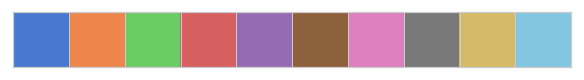

In [3]:
# ==============
# Chouse color
# ==============
sns.palplot(sns.color_palette("muted"))  # show color
sns.set_palette("muted") # for seaborn
colors = sns.color_palette("muted") # for pyplot

### Functions 

In [4]:
# ------------------------------- FUNCIONES ---------------------------------------- #

def woe(catvar,target, data):
    data_aggr = data.groupby([catvar,target]).size().reset_index()
    data_aggr.columns = [catvar,'target','numreg']
    
    # calculamos totales target
    non_event_total= np.sum(data_aggr[data_aggr.target==0]['numreg'])
    event_total = np.sum(data_aggr[data_aggr.target==1]['numreg']) 
    
    # pivoteamos data frame
    data_aggr = data_aggr.pivot(index=catvar, columns='target', values='numreg').reset_index()
    data_aggr.columns = [catvar,'non_event','event']
    
    # calculamos rate de event
    data_aggr['event_rate'] = data_aggr['event']/event_total
    data_aggr['non_event_rate'] = data_aggr['non_event']/non_event_total
    
    # calculamos woe
    data_aggr['woe'] = np.log(data_aggr['event_rate']/data_aggr['non_event_rate'])
    
    # calculamos IV
    data_aggr['rate_diff'] = data_aggr['event_rate'] - data_aggr['non_event_rate']
    data_aggr['information_value'] = data_aggr['rate_diff']*data_aggr['woe']
    #data_aggr['IV'] = data_aggr['IV'].sum()
    
    
    return data_aggr[[catvar,'woe','information_value','event_rate','non_event_rate']]

In [5]:
def info_value(woe_data):
    iv = woe_data['information_value'].sum()
    predictive_power = ""
    if iv < 0.02:
        predictive_power = "useless for prediction"
    elif iv >= 0.02 and iv < 0.1:
        predictive_power = "weak predictor"
    elif iv >= 0.1 and iv < 0.3:
        predictive_power = "medium predictor"
    elif iv >= 0.3 and iv < 0.5:
        predictive_power = "strong predictor"
    else:
        predictive_power = "suspicious predictor"
        
    return iv,predictive_power

In [6]:
def barprop(yvalue, xvalue, stitle, size, data):
    table=pd.crosstab(data[xvalue],data[yvalue])
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.figure(figsize=size)
    
    if len(stitle)==0: # default title
        stitle = "Proportion bar graph"
    
    plt.title(stitle)
    plt.xlabel(xvalue)
    plt.ylabel(yvalue)
    plt.legend(train[yvalue].unique(),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pass

In [7]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

In [9]:
# =========================
#  Histogram
# =========================
def simpleHistGraph(numvar,  data, bins=10):
    g = data[numvar].hist(bins=bins)
    g.set_title(numvar +" distribucion ")
    pass

In [10]:
def countBarPlot(catvar, data, scale="linear", orient="h", rot=0, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    g = sns.countplot(x = catvar, data=data, orient=orient)
    loc, labels = plt.xticks()
    g.set_xticklabels(labels, rotation=rot)
    g.set_yscale(scale)
    
    g.set_title("Number of cases by " + catvar.upper())
    plt.show()
    pass

### Load Data

In [11]:
# Load Train Data
rawdata = pd.read_csv(data_path + 'train.csv',sep=',')

### Describe Data

In [12]:
rawdata.shape

(1804874, 45)

In [13]:
rawdata.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [14]:
rawdata.sample(n=5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
681873,1075748,0.0,"<a href=""https://www.wingovtjobs.com/central-g...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-04 06:50:36.122638+00,66,NaN,316768,rejected,0,0,0,0,0,0.0,0,4
866631,5181050,0.0,Jays still m aking it hard on themselves. At o...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-04-26 14:57:01.160026+00,54,NaN,329792,approved,0,0,0,1,0,0.0,0,4
1115380,5479210,0.0,October 2025?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-06-26 16:47:42.330495+00,54,5478876.0,348664,approved,2,0,3,7,0,0.0,4,4
457268,804880,0.5,Thank God that is in Colorado. If it were her...,0.0,0.4,0.0,0.4,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-07 14:37:40.559715+00,13,NaN,160604,approved,1,0,0,0,1,0.0,0,10
1338528,5751254,0.0,It applies to the hot tub guy.,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-11 18:03:23.107562+00,102,5750957.0,365420,approved,0,0,0,0,1,0.0,0,4


In [15]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
id                                     int64
target                                 float64
comment_text                           object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float

In [21]:
rawdata.describe(include=['O']) # category data

,comment_text,created_date,rating
count,1804874,1804874,1804874
unique,1780823,1804362,2
top,Well said.,2015-09-29 19:35:42.710047+00,approved
freq,184,4,1684758


In [22]:
rawdata.describe() # numerical data

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,publication_id,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.00000,1.804874e+06,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,0.001410,0.095268,0.127670,0.003237,0.001457,0.025611,0.001088,0.017863,0.006127,0.108687,0.049460,0.001220,0.000884,0.008248,0.006761,0.001494,0.001356,0.012083,0.006724,0.05695,4.986296e+01,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,2.445187e+06,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,0.030923,0.256671,0.305384,0.045801,0.030862,0.143739,0.016032,0.122145,0.058684,0.267894,0.202459,0.014102,0.011853,0.042717,0.037504,0.015374,0.017505,0.089183,0.069027,0.21596,2.769869e+01,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000e+00,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.100000e+01,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,5.400000e+01,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,5.769854e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,5.400000e+01,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1

In [23]:
print(rawdata.nunique())

id                                     1804874
target                                    2913
comment_text                           1780823
severe_toxicity                           1460
obscene                                   2417
identity_attack                           2294
insult                                    3042
threat                                    2053
asian                                      125
atheist                                     84
bisexual                                    85
black                                      127
buddhist                                    64
christian                                  160
female                                     204
heterosexual                               125
hindu                                       77
homosexual_gay_or_lesbian                  124
intellectual_or_learning_disability         76
jewish                                     120
latino                                     104
male         

### Missing value analysis

In [24]:
# To check if there are any null values in the dataset
rawdata.isnull().values.any() 

True

In [25]:
rawdata.isnull().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

### Explore Numerical Data

In [ ]:
# =========================
#  Target Barplot (count)
# =========================
plt.figure(figsize=(10, 6))
sns.countplot(x=target, data=rawdata)
pass

In [ ]:
# ====================
#  Boxplot
# ====================
sns.set(style="whitegrid") # Background graph style : whitegrid, darkgrid
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="catvar", y="numvar", 
                #hue = "catvar or target",
                 orient="v",  # "v" | "h", optional
                 linewidth=1.5,
                 palette="Set2" # Colors to use for the different levels of the hue variable.
                 data=rawdata) # DataFrame, array, or list of arrays, optional
ax.set_title("Default | title")
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)
pass

In [ ]:
# =================================================
#  Scatterplot Matrix (Scatterplot + distribution)
# =================================================

var = ["numvar1", "numvar2",.. "numvarn", target] # put all the numeric vars to analyze + target (or categoical value used in hue) 
         # exp: ["numvar1", "numvar2",.. "numvarn", target]
         # Note: drop null values with dropna function.
        
plt.figure(figsize=(18, 18))
g = sns.pairplot(rawdata[var], 
                  hue=target, 
                  palette = colors,
                  markers=["o", "s", "D"], # In the hue variable so that differently colored points 
                                           # will also have different scatterplot markers.
                 kind='scatter' # 'scatter' or 'reg' Kind of plot for the non-identity relationships.
                 )


# To change the size of the scatterpoints in graph
g = g.map_offdiag(plt.scatter,  s=35,alpha=0.5)

# remove the top and right line in graph
sns.despine()

# Additional line to adjust some appearance issue
plt.subplots_adjust(top=0.9)

# Set the Title of the graph from here
g.fig.suptitle('Relation between ' + ', '.join([s  for s in var[:len(var)-1]]) + ' and ' + var[len(var)-1],
	fontsize=14,color="black",alpha=0.7)

pass

In [ ]:
# =======================================
#  Scater plot + distribution + line reg
#  2 numerical vars
# =======================================
plt.figure(figsize=(12,12))
sns.jointplot("var1", "var2", data=rawdata, kind="reg", annot_kws=dict(stat="r"))
pass

In [ ]:
# ====================
#  HeatMap Correlation
# ====================

# select only numerical data. Drop or replace null values
col_names = ['fct_VoucherPrecioProducto', 'fct_CostoLogistica', 'fct_CostoDiagnostico']
colormap = plt.cm.RdBu
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(rawdata[col_names].astype(float).corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
pass

In [ ]:
# =====================
#  Matrix distribution 
# =====================

# select only one numerical value and 2 categorical. Drop or replace null values

col_names = ['numvar', 'catvar1', 'catvar2']
g = sns.FacetGrid(rawdata, row=col_names[1], col=col_names[2])
g.map(sns.distplot, col_names[0])
plt.show()

### Explore Categorical Data

In [ ]:
plt.figure(figsize=(12,12))
df = rawdata.pivot_table(index='catvar1', columns='catvar2', 
                         values='numvar or id', 
                         aggfunc=np.count_nonzero) # chouse a math function from numpy
sns.heatmap(df, annot=True, fmt=".1f")
plt.show()

### Outlier detection analysis

In [ ]:

# select only numerical values.
col_names = ['numvar0','numvar1', 'numvar2', 'numvar3',..., 'numvarN']

fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):

    sns.boxplot(y=sales_data_hist[col_val], ax=ax[i])
    ax[i].set_title('Box plot - {}'.format(col_val), fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)

plt.show()

In [ ]:
fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
    x = rawdata[col_names][:1000]
    sns.distplot(x, ax=ax[i], rug=True, hist=False)
    outliers = x[percentile_based_outlier(x)]
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    ax[i].set_title('Outlier detection - {}'.format(col_val), fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)

plt.show()